In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [26]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import select

# Path to sqlite
database_path = "./Resources/hawaii.sqlite"

In [28]:
# Create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

In [29]:
# Connect to SQL database
conn = engine.connect()

In [30]:
query = "SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name"
data = engine.execute(query)

for record in data:
    print(record)
    

('measurement',)
('station',)


In [31]:
query = 'SELECT * FROM measurement LIMIT 10'

data = engine.execute(query)

for record in data:
    print(record)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
(6, 'USC00519397', '2010-01-07', 0.06, 70.0)
(7, 'USC00519397', '2010-01-08', 0.0, 64.0)
(8, 'USC00519397', '2010-01-09', 0.0, 68.0)
(9, 'USC00519397', '2010-01-10', 0.0, 73.0)
(10, 'USC00519397', '2010-01-11', 0.01, 64.0)


In [32]:
data = pd.read_sql('SELECT * FROM measurement', conn)
data.head()


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [33]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [34]:
# View all of the classes that automap found
for c in Base.classes:
    print(c)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [37]:
stations = session.query(Station)

for station in stations:
    print(station.name)

WAIKIKI 717.2, HI US
KANEOHE 838.1, HI US
KUALOA RANCH HEADQUARTERS 886.9, HI US
PEARL CITY, HI US
UPPER WAHIAWA 874.3, HI US
WAIMANALO EXPERIMENTAL FARM, HI US
WAIHEE 837.5, HI US
HONOLULU OBSERVATORY 702.2, HI US
MANOA LYON ARBO 785.2, HI US


# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
query = select(Measurement.date)
print(query)

SELECT measurement.date 
FROM measurement


In [39]:
dates = session.execute(query)
dates = list(dates)
most_recent_date = max(dates)
most_recent_date[0]

'2017-08-23'

In [ ]:
session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= dt.date(2017, 8, 23) - dt.timedelta(days = 365)).\
    order_by(Measurement.date).all()

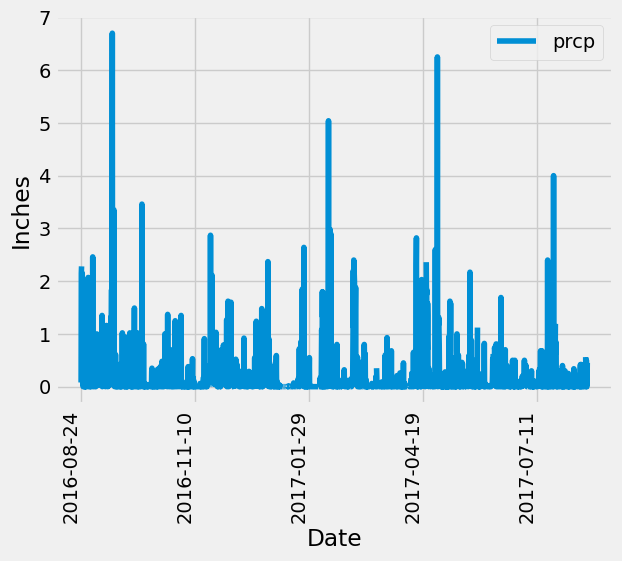

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
twelve_month_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(twelve_month_data).set_index('date')


# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot()
plt.xticks(rotation=90, ha='right')
ax.set_ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [49]:
# Design a query to calculate the total number stations in the dataset

station_count = session.query(Measurement).group_by(Measurement.station).count()
station_count


9

In [51]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_descending = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_descending

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_descending[0][0]).all()
station_stats

[(54.0, 85.0, 71.66378066378067)]

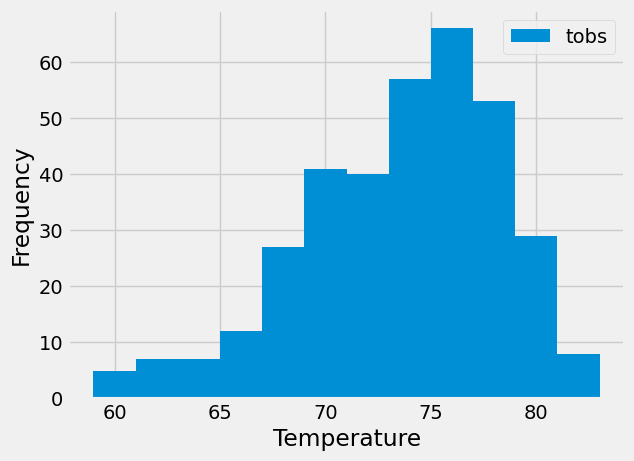

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).\
    filter(Measurement.date >= last_year).\
    filter(Measurement.station == station_descending[0][0]).\
    order_by(Measurement.date).all()

tobs_df = pd.DataFrame(tobs_results)

tobs_df.plot(kind='hist', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [47]:
# Close Session
conn.close()